<h3>Problem Statement</h3> <br>


New York City, the busiest city in the entire world. The city is filled with one-way roads, small streets and incalculable pedestrians. There is always a mad rush to get from point A to point B, due to which the roads are clogged with cars, bicycles, motorcycles etc. For this reason, the yellow taxis (**medallion taxis**) and the green taxis (**boro taxis**) are quite famous in NYC. But off late, there has been stiff competition from ridesharing services companies like Uber/ Lyft/ Jayride etc. due to which there has been decline in overall riders.

Therefore companies like **New York City Taxi and Limousine Commission (TLC)** are looking out for options to improve the efficiency of their taxi dispatching systems. It is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request. 


In [1]:
# importing libraries for data analysis and linear algebra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from math import sqrt

# For Machine Learning Modelling and evaluation
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# restrict the display of warning messages
import warnings
warnings.filterwarnings('ignore')


In [2]:
# importing dataset
dateparse = lambda dates: pd.to_datetime(dates)
nyc_df = pd.read_csv("nyc_taxi_trip_duration.csv",
                     parse_dates=['pickup_datetime','dropoff_datetime'], date_parser=dateparse)
nyc_df.shape

(729322, 11)

In [5]:
# Viewing the data
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [6]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  729322 non-null  object        
 1   vendor_id           729322 non-null  int64         
 2   pickup_datetime     729322 non-null  datetime64[ns]
 3   dropoff_datetime    729322 non-null  datetime64[ns]
 4   passenger_count     729322 non-null  int64         
 5   pickup_longitude    729322 non-null  float64       
 6   pickup_latitude     729322 non-null  float64       
 7   dropoff_longitude   729322 non-null  float64       
 8   dropoff_latitude    729322 non-null  float64       
 9   store_and_fwd_flag  729322 non-null  object        
 10  trip_duration       729322 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 61.2+ MB


In [7]:
nyc_df.describe(include = "all")

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,729322,729322.000000,729322,729322,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322,7.293220e+05
unique,729322,NaN,709359,709308,NaN,NaN,NaN,NaN,NaN,2,NaN
top,id0418900,NaN,2016-05-20 09:03:18,2016-02-27 19:23:54,NaN,NaN,NaN,NaN,NaN,N,NaN
freq,1,NaN,4,4,NaN,NaN,NaN,NaN,NaN,725282,NaN
first,NaN,NaN,2016-01-01 00:01:14,2016-01-01 00:05:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-06-30 23:59:37,2016-07-01 23:02:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.535403,NaN,NaN,1.662055,-73.973513,40.750919,-73.973422,40.751775,NaN,9.522291e+02
std,NaN,0.498745,NaN,NaN,1.312446,0.069754,0.033594,0.069588,0.036037,NaN,3.864626e+03
min,NaN,1.000000,NaN,NaN,0.000000,-121.933342,34.712234,-121.933304,32.181141,NaN,1.000000e+00
25%,NaN,1.000000,NaN,NaN,1.000000,-73.991859,40.737335,-73.991318,40.735931,NaN,3.970000e+02


### Data Integrity check

In [8]:
print('No of Duplicates, Trip IDs: {}'.format(len(nyc_df) - len(nyc_df.drop_duplicates(subset='id'))))

print('No of Incorrect trip durations: {}'.format((nyc_df.trip_duration != nyc_df.dropoff_datetime.sub(nyc_df.pickup_datetime, axis=0) / 
                                                   np.timedelta64(1, 's')).sum()))


No of Duplicates, Trip IDs: 0
No of Incorrect trip durations: 0


In [9]:
for var in nyc_df.columns:
    print('{} has {} unique values'.format(var,len(nyc_df[var].unique())))

id has 729322 unique values
vendor_id has 2 unique values
pickup_datetime has 709359 unique values
dropoff_datetime has 709308 unique values
passenger_count has 9 unique values
pickup_longitude has 19729 unique values
pickup_latitude has 39776 unique values
dropoff_longitude has 27892 unique values
dropoff_latitude has 53579 unique values
store_and_fwd_flag has 2 unique values
trip_duration has 6296 unique values


*vendor_id* has 2 discrete values only i.e. 1 or 2 and it is a unique id for each vendor. Therefore these can be converted to **category** 

In [10]:
nyc_df['vendor_id'] = nyc_df['vendor_id'].astype('object')
#nyc_df['passenger_count'] = nyc_df['passenger_count'].astype('category')

# Data Exploration

The dataset contains 10 independent variables and 1 dependent variable (trip duration). We'll explore them starting with the target variable.

In [11]:
# Helper Function to study numerical/continuous variables in the dataset

def numeric_EDA(data,columns,outlier_inc = True):
    
    for i,var in enumerate(columns):
        new_df = data.copy()
        IQR = new_df[var].quantile(0.75) - new_df[var].quantile(0.25)
        ub = new_df[var].quantile(0.75) + (IQR*1.5)
        lb = new_df[var].quantile(0.25) - (IQR*1.5)

        plt.figure(figsize = (15,5))
        if outlier_inc == False:
            new_df = new_df.loc[new_df[var] < ub]
            new_df = new_df.loc[new_df[var] > lb]

            print("Distribution of {} after outliers removal\nMean = {}, Std. Dev. = {}, Median = {}, IQR = {} \n".format(
            var, np.mean(new_df[var]), np.std(new_df[var]), np.median(new_df[var]), new_df[var].quantile(0.75) - new_df[var].quantile(0.25)))

            plt.subplot(i+1,2,1)
            sns.distplot(new_df[var], bins=100)

            plt.subplot(i+1,2,2)
            sns.boxplot(var, data = new_df)
            plt.show()

        else:
            print("Distribution of {} before outliers removal\nMean = {}, Std. Dev. = {}, Median = {}, IQR = {} \n".format(
            var, np.mean(new_df[var]), np.std(new_df[var]), np.median(new_df[var]), IQR))

            plt.subplot(i+1,2,1)
            sns.distplot(new_df[var], bins=100)

            plt.subplot(i+1,2,2)
            sns.boxplot(var, data = new_df)
            plt.show()
    
    

In [12]:
# Helper Function to study discrete/categorical variables in the dataset

def categorical_EDA(data,variable):
    plt.figure(figsize=(10,5))
    val_cnt = data[variable].value_counts()/data.shape[0]
    sns.barplot(x=val_cnt.index, y=val_cnt)
    plt.title('Percentage distribution of {}\nValue Counts:\n{}'.format(variable,data[variable].value_counts()),fontsize=15)
    plt.xlabel(variable,fontsize=12)
    plt.ylabel('Percentage',fontsize=12)
    sns.set(style="whitegrid")
    

### `Target variable exploration`

Distribution of trip_duration before outliers removal
Mean = 952.2291333594764, Std. Dev. = 3864.62354781523, Median = 663.0, IQR = 678.0 



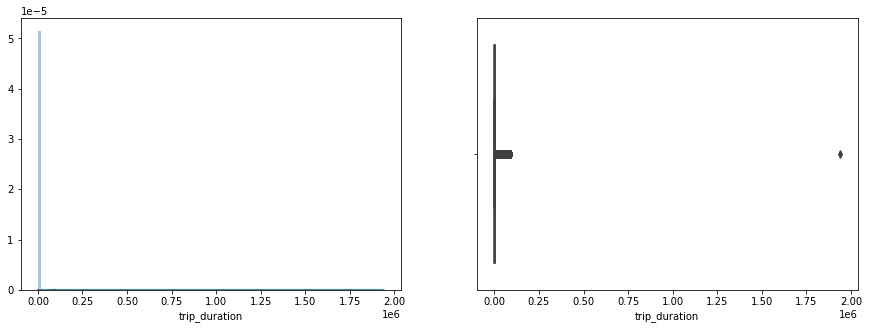

In [13]:
numeric_EDA(nyc_df,["trip_duration"])

In [14]:
(nyc_df["trip_duration"]/3600).describe()

count    729322.000000
mean          0.264508
std           1.073507
min           0.000278
25%           0.110278
50%           0.184167
75%           0.298611
max         538.815556
Name: trip_duration, dtype: float64

* *trip_duration* is seen to be containing good amount of outliers as their are trips of 1 second upto 538 hours.
* A trip of 1 second or 538 hours duration, doesn't seem make any sense. This must be a clear case of incorrect data entry by some means.
* Also due to the presence of these outliers, it is difficult to understand it's distribution. We'll try studying the distribution by ignoring these outliers.

Distribution of trip_duration after outliers removal
Mean = 732.0527263798009, Std. Dev. = 448.1062744767904, Median = 632.0, IQR = 607.0 



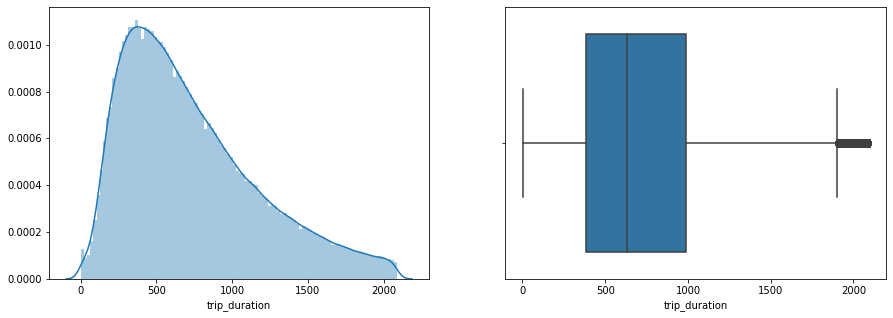

In [15]:
numeric_EDA(nyc_df,["trip_duration"],False)

* A good left skewed distribution of ***trip_duration*** variable can be observed after removing the outliers.
* We can notice the change in the mean and standard deviation and understand the effect that the outliers are having on the overall distribution.
* Majority of the trip duration lasted between **397 secs to 1075 secs** which is evident from the boxplot.

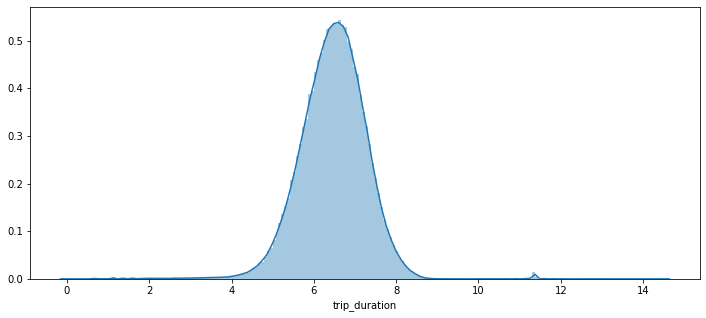

In [16]:
#nyc_df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
#sns.set(style='white')
plt.figure(figsize=(12,5))
sns.distplot(np.log(nyc_df['trip_duration']), bins = 200)
plt.show()

## Univariate Analysis

### `Latitude and Longitude variables`

Distribution of pickup_longitude before outliers removal
Mean = -73.97351307454848, Std. Dev. = 0.06975379242946964, Median = -73.98175811767578, IQR = 0.02449798583984375 



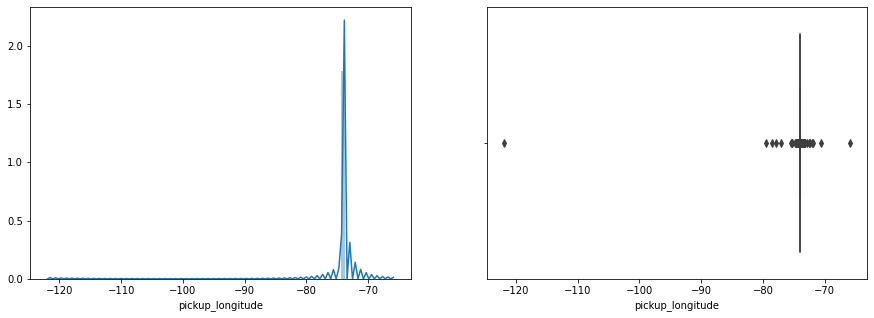

Distribution of dropoff_longitude before outliers removal
Mean = -73.97342219209891, Std. Dev. = 0.0695881090724019, Median = -73.9797592163086, IQR = 0.02828216552732954 



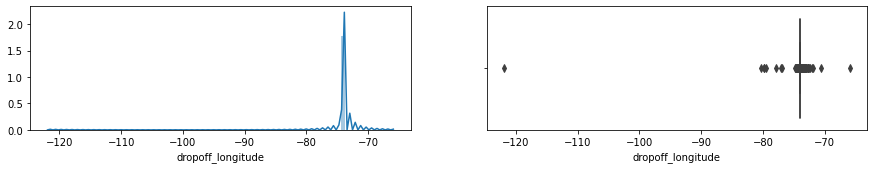

In [17]:
numeric_EDA(nyc_df,["pickup_longitude","dropoff_longitude"])

Distribution of pickup_longitude after outliers removal
Mean = -73.98141150823888, Std. Dev. = 0.01648306940073854, Median = -73.98252868652342, IQR = 0.02164459228515625 



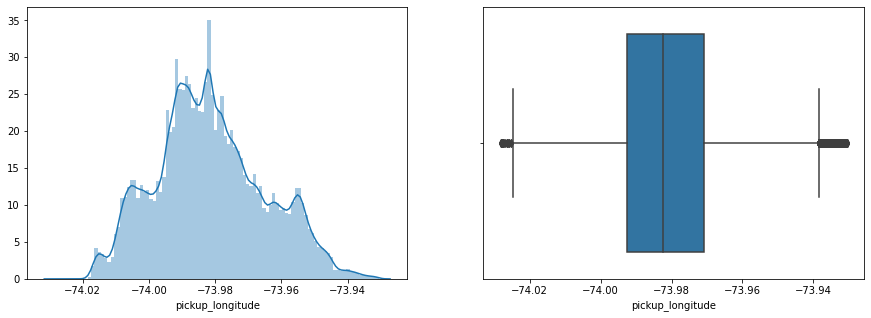

Distribution of dropoff_longitude after outliers removal
Mean = -73.9790089939866, Std. Dev. = 0.018609932369102248, Median = -73.98086547851562, IQR = 0.02478790283203125 



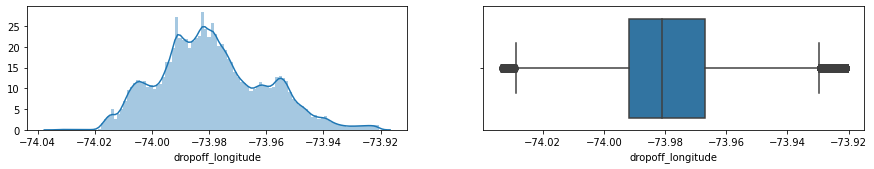

In [18]:
numeric_EDA(nyc_df,["pickup_longitude","dropoff_longitude"], False)

Distribution of pickup_latitude before outliers removal
Mean = 40.75091887972495, Std. Dev. = 0.03359409769015785, Median = 40.754070281982415, IQR = 0.03097915649413352 



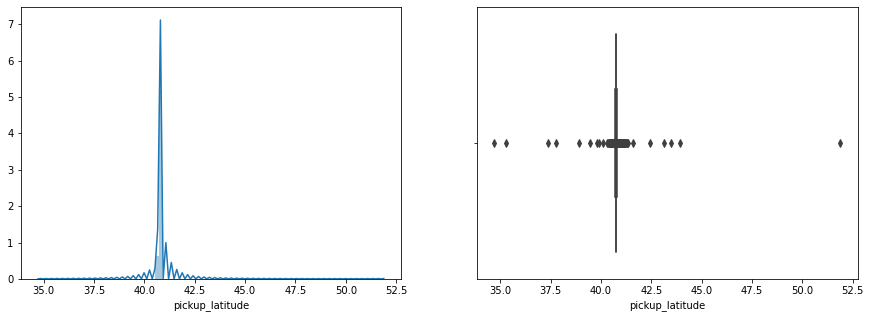

Distribution of dropoff_latitude before outliers removal
Mean = 40.751775436975464, Std. Dev. = 0.03603718638132678, Median = 40.75450897216797, IQR = 0.033809661865234375 



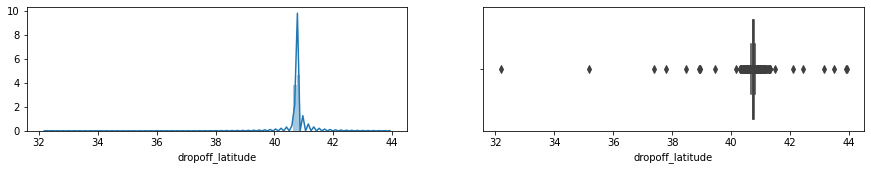

In [19]:
numeric_EDA(nyc_df,["pickup_latitude","dropoff_latitude"])

Distribution of pickup_latitude after outliers removal
Mean = 40.753556574022824, Std. Dev. = 0.021558552838087938, Median = 40.75503158569336, IQR = 0.029201507568359375 



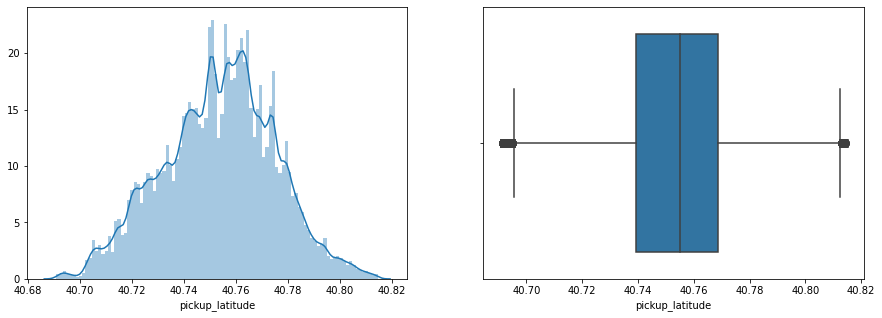

Distribution of dropoff_latitude after outliers removal
Mean = 40.753364258500945, Std. Dev. = 0.024281938328985904, Median = 40.75506591796875, IQR = 0.031162261962890625 



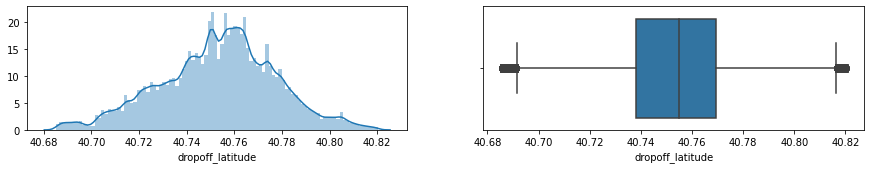

In [20]:
numeric_EDA(nyc_df,["pickup_latitude","dropoff_latitude"],False)

#### Summary of Latitude and Longitude data

* The pickup and dropoff locations are spread over a good range. Some of the locations are not from the usual locations which is evident from the overall spread. The boxplots shows some of the rare geolocation involved in a taxi trip.

* The *pickup_longitude* and *dropoff_longitude* follows a similar kind of distribution. It is quite expected as the trips are only New York City.

* For *pickup_latitude* and *dropoff_latitude* they follow different distribution though somewhat similar in shape.

* Most of pickup and dropoff latitude are in **[40.73 - 40.76]** and longitude in **[-73.99 - -73.96]** .

* These geospatial information is crucial and can be explored more in-depth. Feature engineering will be applied on these to extract informations like distance between point A and B, pickup clusters etc.

### `Categorical Variables`

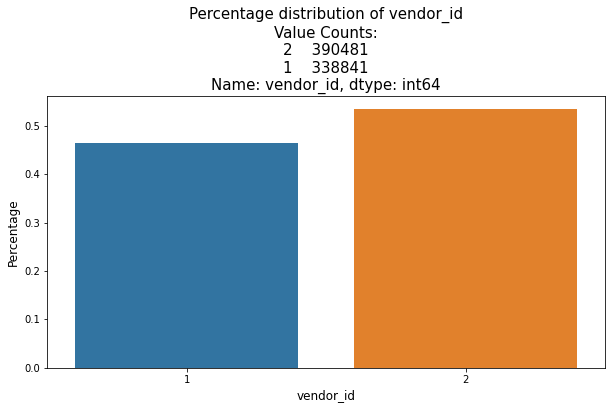

In [21]:
categorical_EDA(nyc_df,'vendor_id')

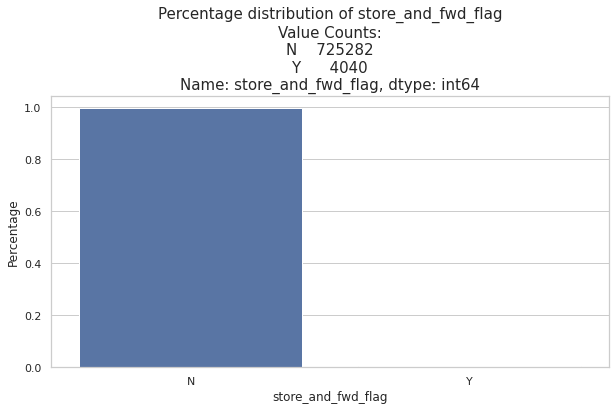

In [22]:
categorical_EDA(nyc_df,'store_and_fwd_flag')

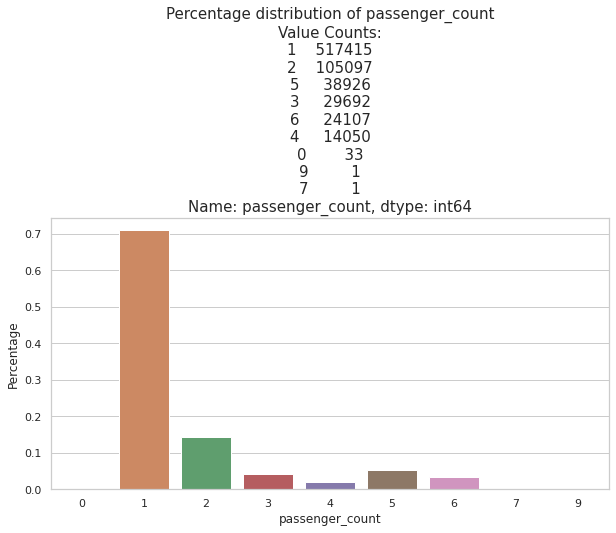

In [23]:
categorical_EDA(nyc_df,'passenger_count')

**Observations:**

* Vendor 2 has more trips in comparision to vendor 1.
* For most of the trips, data were recorded and sent to the vendor (store_and_fwd_flag = 'N'). Very few trips which held the trip data in memory (store_and_fwd_flag = 'Y'), may be due to server connectivity issues.
* Most of the trips are taken by single passenger. Some trips have 0/7/9 passengers, which is unusual. These passenger_count information can be discarded from data.

### DateTime Feature Extraction

* The taxi trip duration is very likely to be associated to different date and time features like weekday or not, hour of the taxi ride, month/season etc.
* As we have the DateTime data for every taxi ride, it'd be good idea to add extra features and study the underlying trends.

In [24]:
nyc_df['pickup_day'] = nyc_df['pickup_datetime'].dt.day
nyc_df['pickup_weekday'] = nyc_df['pickup_datetime'].dt.weekday
nyc_df['pickup_weekofyear'] = nyc_df['pickup_datetime'].dt.weekofyear
nyc_df['pickup_month'] = nyc_df['pickup_datetime'].dt.month
nyc_df['pickup_hour'] = nyc_df['pickup_datetime'].dt.hour
nyc_df['pickup_minute'] = nyc_df['pickup_datetime'].dt.minute
nyc_df['pickup_date'] = pd.to_datetime(nyc_df['pickup_datetime'].dt.date)
#nyc_df['pickup_date'] = nyc_df['pickup_datetime'].apply(lambda x: x.date())

#df.rename(columns = {'pickup_datetime':'pickup_date', 'dropoff_datetime':'dropoff_date'}, inplace = True) 

In [25]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  729322 non-null  object        
 1   vendor_id           729322 non-null  object        
 2   pickup_datetime     729322 non-null  datetime64[ns]
 3   dropoff_datetime    729322 non-null  datetime64[ns]
 4   passenger_count     729322 non-null  int64         
 5   pickup_longitude    729322 non-null  float64       
 6   pickup_latitude     729322 non-null  float64       
 7   dropoff_longitude   729322 non-null  float64       
 8   dropoff_latitude    729322 non-null  float64       
 9   store_and_fwd_flag  729322 non-null  object        
 10  trip_duration       729322 non-null  int64         
 11  pickup_day          729322 non-null  int64         
 12  pickup_weekday      729322 non-null  int64         
 13  pickup_weekofyear   729322 no

Text(0, 0.5, 'Total pickups in %')

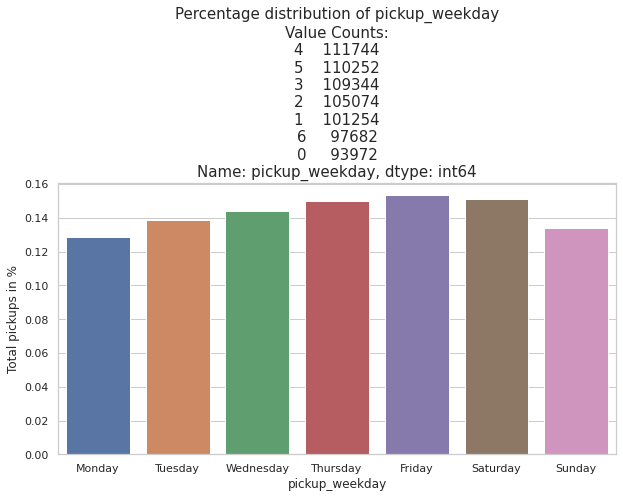

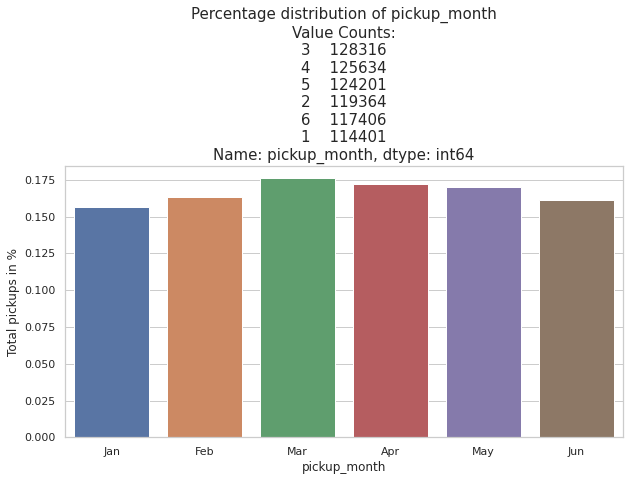

In [26]:
#plt.figure(figsize=(20, 6), dpi = 200)

# pickup_weekday
#plt.subplot(121)
#sns.countplot(nyc_df['pickup_weekday'])
categorical_EDA(nyc_df, 'pickup_weekday')
tick_val=[0, 1, 2, 3, 4, 5, 6]
tick_lab=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(tick_val, tick_lab)
plt.ylabel('Total pickups in %')

# pickup_month
#plt.subplot(122)
categorical_EDA(nyc_df, 'pickup_month')
tick_val=[0, 1, 2, 3, 4, 5]
tick_lab=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
plt.xticks(tick_val, tick_lab)
plt.ylabel('Total pickups in %')


Text(0, 0.5, 'Total number of pickups')

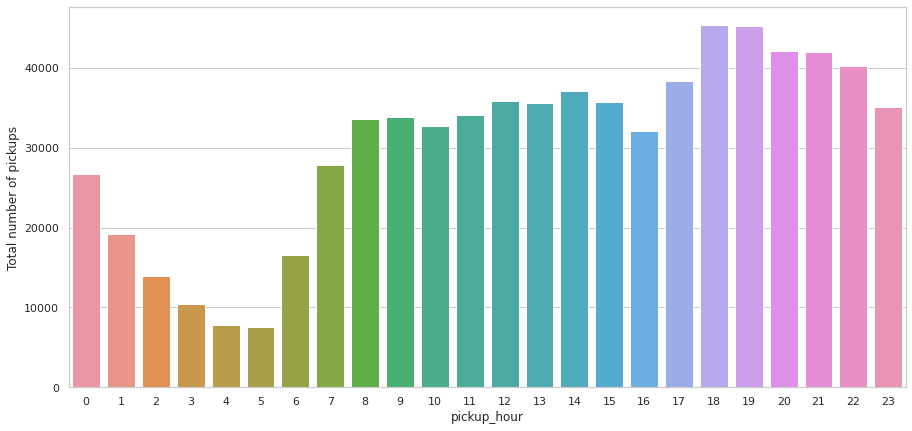

In [27]:
plt.figure(figsize=(15,7))
sns.countplot(nyc_df['pickup_hour'])
plt.ylabel('Total number of pickups')

## Bivariate Analysis

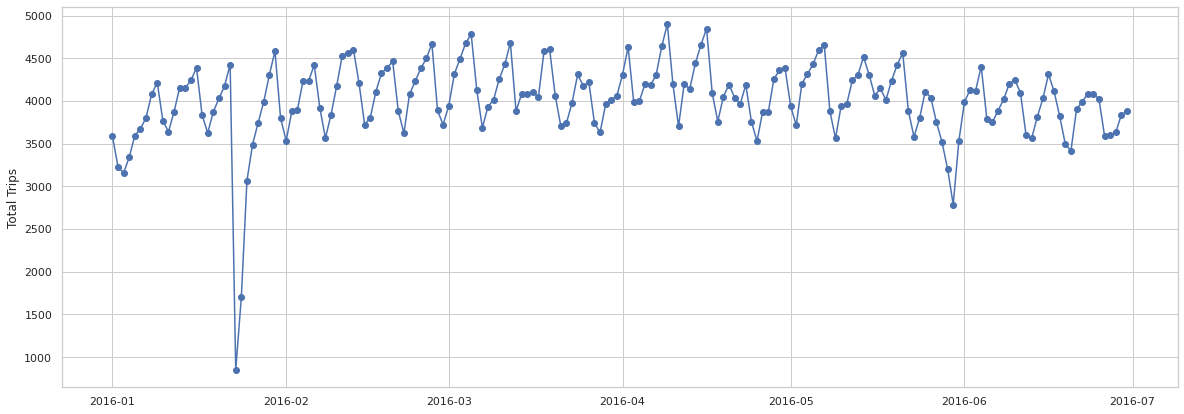

In [28]:
#df = nyc_df.copy()
#df['pickup_date'] = nyc_df['pickup_datetime'].dt.date

plt.figure(figsize=(20,7))
plt.plot(nyc_df.groupby('pickup_date').count()['id'], 'o-')
plt.ylabel('Total Trips')
plt.show()

* A good seasonality of no. of trips is observed across each week for 6 months of sample data. When observed closely, monday and sunday has lesser no. of taxi trips compared to other days in a week. 
* One interesting insight can be observed from the plot, there is a massive drop in total trips on *23rd January,2016*. This was because of the **January 2016 United States Blizzard** . It was then the biggest snowstorm witnessed across U.S which spanned between January 22-24.

Text(0.5, 1.0, 'Median trip duration per hour in a day')

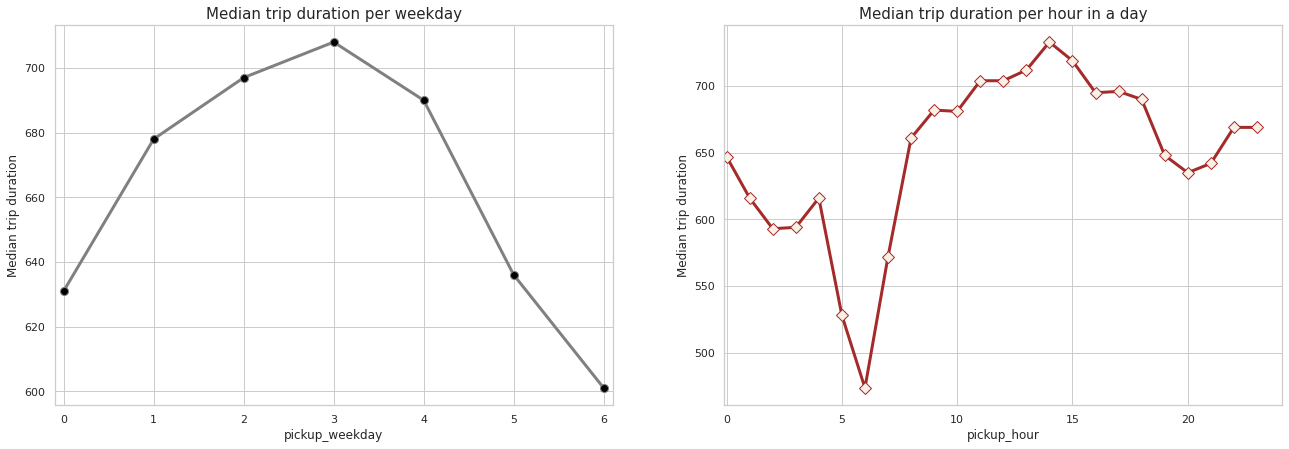

In [29]:
df = nyc_df.loc[nyc_df['trip_duration'] < nyc_df['trip_duration'].max()]
data1 = df.groupby('pickup_weekday').median()['trip_duration']
data2 = df.groupby('pickup_hour').median()['trip_duration']

plt.figure(figsize=(22,7))

plt.subplot(121)
#sns.lineplot(x = data1.index, y = data1, marker = 'o')
data1.plot(kind = 'line', marker='o', markerfacecolor='black', markersize=8, color='gray', linewidth=3)
plt.xlim(-0.1,6.1)
plt.ylabel('Median trip duration')
plt.title('Median trip duration per weekday', fontsize = 15)

plt.subplot(122)
#sns.lineplot(x = data2.index, y = data2, marker = 'o')
data2.plot(kind = 'line', marker='D', markerfacecolor='linen', markersize=8, color='brown', linewidth=3)
plt.xlim(-0.1,24.1)
plt.ylabel('Median trip duration')
plt.title('Median trip duration per hour in a day', fontsize = 15)


* The median trip duration is comparatively less on Monday, Saturday and Sunday compared to other weekdays. This can be attributed towards lower traffic densities seen across these particular days.
* Also the trip duartion are shorter during the early morning hours i.e. *5 a.m - 7 a.m*. Likewise the trip duration is more during the office working hours i.e. *9 a.m -6 p.m*.
* This follows similar pattern when compare to the total no. pickups per hour. This indicates, there would be a good correlation between *pickup_hour* and *trip_duration*.

Text(0.5, 1.0, 'Average trip duration by passenger count')

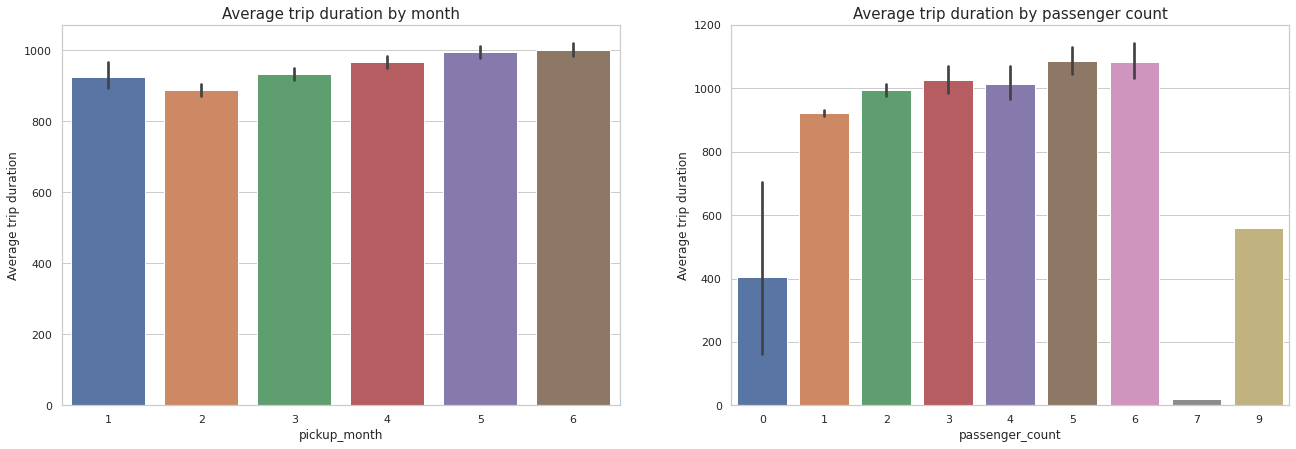

In [30]:
plt.figure(figsize=(22,7))

plt.subplot(121)
sns.barplot(y = 'trip_duration', x = 'pickup_month', data = nyc_df)
#data1.plot(kind = 'line', marker='o', markerfacecolor='black', markersize=8, color='gray', linewidth=3)
plt.ylabel('Average trip duration')
plt.title('Average trip duration by month', fontsize = 15)

plt.subplot(122)
sns.barplot(y = 'trip_duration', x = 'passenger_count', data = nyc_df)
plt.ylabel('Average trip duration')
plt.title('Average trip duration by passenger count', fontsize = 15)


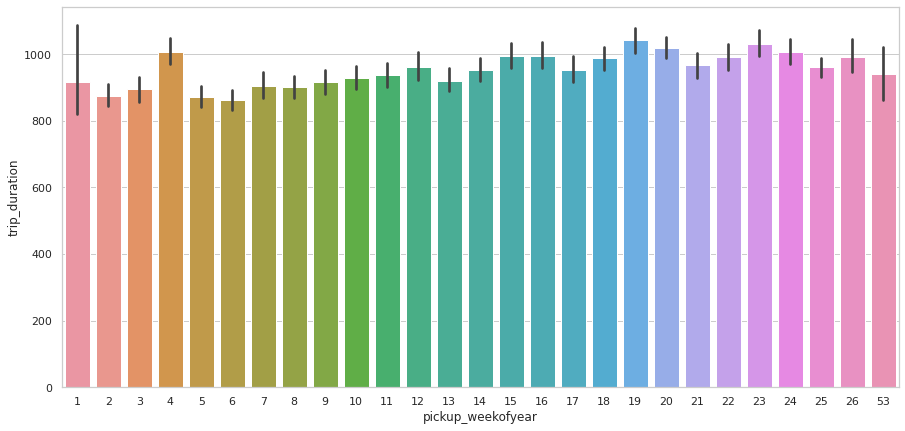

In [31]:
plt.figure(figsize=(15,7))
sns.barplot(y = 'trip_duration', x = 'pickup_weekofyear', data = nyc_df)

In [32]:
nyc_df.loc[nyc_df['pickup_weekofyear'] == 53].sample(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_weekday,pickup_weekofyear,pickup_month,pickup_hour,pickup_minute,pickup_date
584238,id0203864,2,2016-01-03 16:40:01,2016-01-03 16:45:05,1,-73.951614,40.778316,-73.953621,40.766785,N,304,3,6,53,1,16,40,2016-01-03
701131,id2375499,2,2016-01-01 20:38:01,2016-01-02 19:44:58,2,-73.989273,40.726353,-73.991753,40.744301,N,83217,1,4,53,1,20,38,2016-01-01
201768,id1580857,2,2016-01-01 16:06:23,2016-01-01 16:11:18,2,-73.967697,40.802940,-73.974083,40.791512,N,295,1,4,53,1,16,6,2016-01-01


Week 53 is nothing but the first 3 days of the year 2016. We'll have to treat this as it seems like a discontinuation from the regular pattern of no. of weeks in our data.

### Visualizing the pickup and dropoff locations in NYC

To visualize the geospatial locations of NYC, it is important to focus on points which are within the borders of the city. Some of the points spill over and are very away, which may not be useful for our analysis.

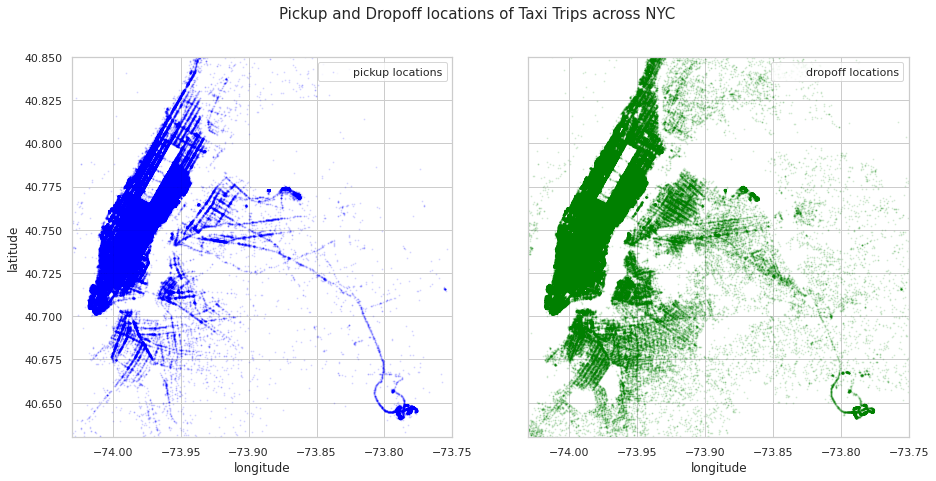

In [33]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(figsize=(15,7), ncols=2, sharex=True, sharey=True)
ax[0].scatter(nyc_df['pickup_longitude'], nyc_df['pickup_latitude'],
              color='blue', s=1, label='pickup locations', alpha=0.1)
ax[1].scatter(nyc_df['dropoff_longitude'], nyc_df['dropoff_latitude'],
              color='green', s=1, label='dropoff locations', alpha=0.1)
fig.suptitle('Pickup and Dropoff locations of Taxi Trips across NYC', fontsize=15)
#ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

* As observed during the univariate analysis, majority of pickup and dropoff locations revolves around **40.675 - 40.850** latitude and **-74.01 - -73.92** longitude
* Few hotspot points like **JFK International Airport** (40.641399, -73.778203) and luxury hotel stays nearby **LaGuardia Airport** (40.770611, -73.869879) which are located far from city has also many pickup and dropoff points. This is obvious as many people are arriving or departing from these locations.

# Feature Engineering

To start off, We'll first filter out the anomalous points observed in *trip_duration* and *passenger_count* variables. We'll remove the trips less than 10 seconds and trip with 538 hours. 

In [34]:
df = nyc_df.copy()

In [35]:
df = df.loc[df['trip_duration'] != df['trip_duration'].max()]
df = df.loc[df['trip_duration'] > 10]
df['trip_duration'].describe()

count    728240.000000
mean        950.971880
std        3129.630824
min          11.000000
25%         398.000000
50%         664.000000
75%        1076.000000
max       86391.000000
Name: trip_duration, dtype: float64

In [36]:
df = df.loc[df['passenger_count'] <= 6]
df = df.loc[df['passenger_count'] != 0]

In [37]:
# Restricting the points which are beyond the borders of NYC
df = df.loc[(df['pickup_longitude'] >= -74.03) & (df['pickup_longitude'] <= -73.75)]
df = df.loc[(df['pickup_latitude'] >= 40.63) & (df['pickup_latitude'] <=  40.85)]
df = df.loc[(df['dropoff_longitude'] >= -74.03) & (df['dropoff_longitude'] <= -73.75)]
df = df.loc[(df['dropoff_latitude'] >= 40.63) & (df['dropoff_latitude'] <=  40.85)]

Now, We'll take the log transformation of *trip_duration* so as to minimize the effect of outliers as well as bring to close to normal distribution. This will help in satisfying the linearity assumption.

In [38]:
df['log_trip_duration'] = np.log(df['trip_duration'].values)

In [39]:
df['log_trip_duration'].describe()

count    718651.000000
mean          6.461064
std           0.769977
min           2.397895
25%           5.978886
50%           6.487684
75%           6.966024
max          11.366639
Name: log_trip_duration, dtype: float64

### `Distance and Direction variables`

This is the interesting part where we use geospatial information to derive distance and direction of trips between two points A to B.

Thanks to Beluga's post in Kaggle https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367 , we can determine the distance and direction of a specific trip based on the pickup and dropoff coordinates.

In [40]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [41]:
df['distance_haversine'] = haversine_array(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)
    
df['direction'] = bearing_array(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)


In [42]:
# Using the distance features, we can derive the average speed of the trip.
df['haversine_average_speed'] = 3600 * df['distance_haversine']/df['trip_duration']

In [43]:
df['haversine_average_speed'].describe()

count    718651.000000
mean         14.195780
std           7.900695
min           0.000000
25%           9.095459
50%          12.717844
75%          17.624613
max        1408.104838
Name: haversine_average_speed, dtype: float64

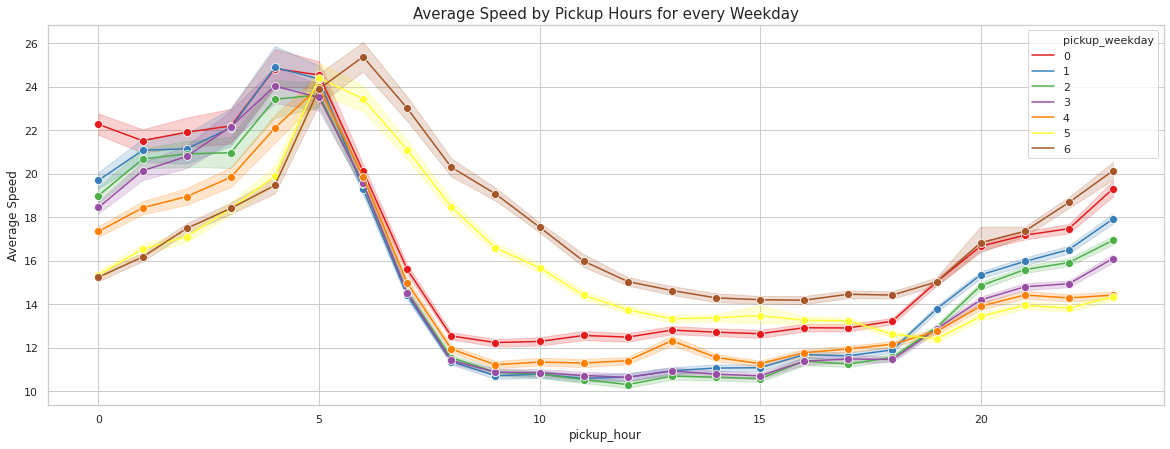

In [44]:

sns.axes_style("darkgrid")
plt.figure(figsize=(20,7))
sns.lineplot(x='pickup_hour', y='haversine_average_speed', hue='pickup_weekday', data=df, marker='o',markersize=8,
             palette=sns.color_palette("Set1", df.pickup_weekday.nunique()))
plt.ylabel('Average Speed')
plt.title('Average Speed by Pickup Hours for every Weekday', fontsize=15)
plt.show()

* It can be observed the average speed of the taxi trips remains low across the peak rush hours i.e. *8 a.m - 6 p.m*. It is obvious as high traffic is seen during the working hours. The average speed starts picking up after 7 p.m till 5 a.m, since most of the people stay indoors during this time.

* As expected, the average speed remains high during the weekend as most of the working people are on leave due to which less congestion on roads.

Note: To use *average_speed* in our model, we'll have to *distance_haversine* variable as using them both will induce multicollinearity.

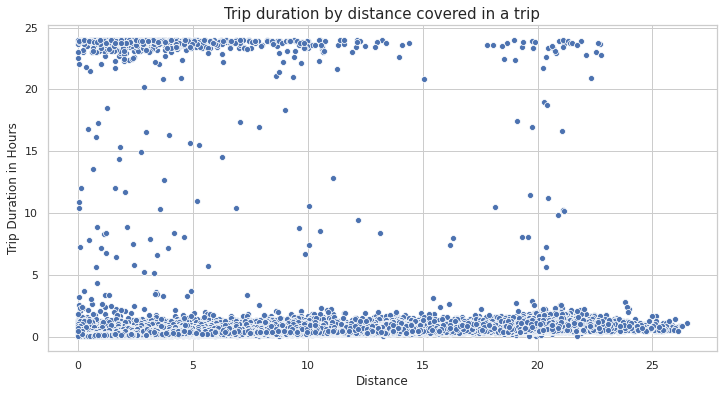

In [45]:
df['trip_duration_hour'] = df['trip_duration']/3600
plt.figure(figsize=(12,6))
sns.scatterplot(x='distance_haversine', y='trip_duration_hour', data=df)
plt.ylabel('Trip Duration in Hours')
plt.xlabel('Distance')

plt.title('Trip duration by distance covered in a trip', fontsize=15)
plt.show()

* It can be observed that majority of trips taken are within 0-25 KMs. There are many trip's with which have a ride duration > 22 Hours whereas the distance covered < 25 KMs. 
* Perhaps these were the trips for which the riders might have booked the taxi for entire day, which is quite reasonable.
* Also, there are some trips with *distance = 0*, whereas *trip_duration > 0*. For such obseravtions, we'll replace the observations with median distance.

In [46]:
print('Total no. of observations with distance = 0 is:',len(df.loc[df['distance_haversine'] == 0]))

# Median imputation
#median_dist = df['distance_haversine'].median()
df = df.loc[df['distance_haversine'] > 0]

Total no. of observations with distance = 0 is: 2382


Now, we will take log transformation of *distance_haversine* and check the relationship with *log_trip_duration*.

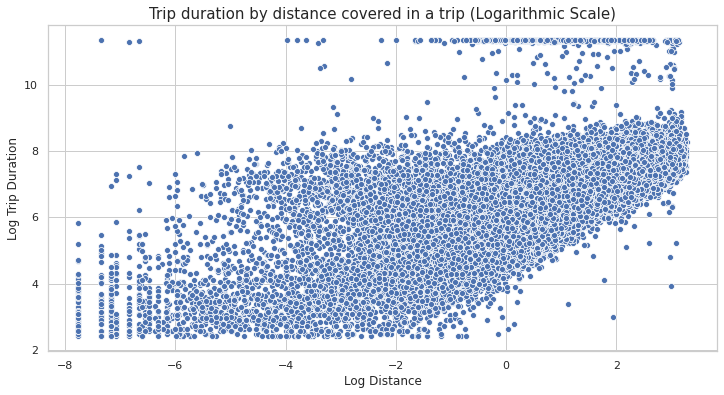

In [47]:
plt.figure(figsize=(12,6))
df['log_distance'] = np.log(df['distance_haversine'].values)

sns.scatterplot(x='log_distance', y='log_trip_duration', data=df)
plt.ylabel('Log Trip Duration')
plt.xlabel('Log Distance')
plt.title('Trip duration by distance covered in a trip (Logarithmic Scale)', fontsize=15)
plt.show()

It can be seen that some points near *log_trip_duration >= 10*, with change in distance the trip duration isn't changing much. Also, there some points near *log_distance <= -7*, with change in trip duration distance isn't varying. Thus it'd a good idea to remove these observations.

In [48]:
print('Total no. of observations with log_trip_duration >= 10 and log_distance <= -7 is:',len(df.loc[(df['log_trip_duration'] >= 10) | (df['log_distance'] <= -7)]))
df = df.loc[df['log_trip_duration'] <= 10]
df = df.loc[df['log_distance'] >= -7]

Total no. of observations with log_trip_duration >= 10 and log_distance <= -7 is: 1134


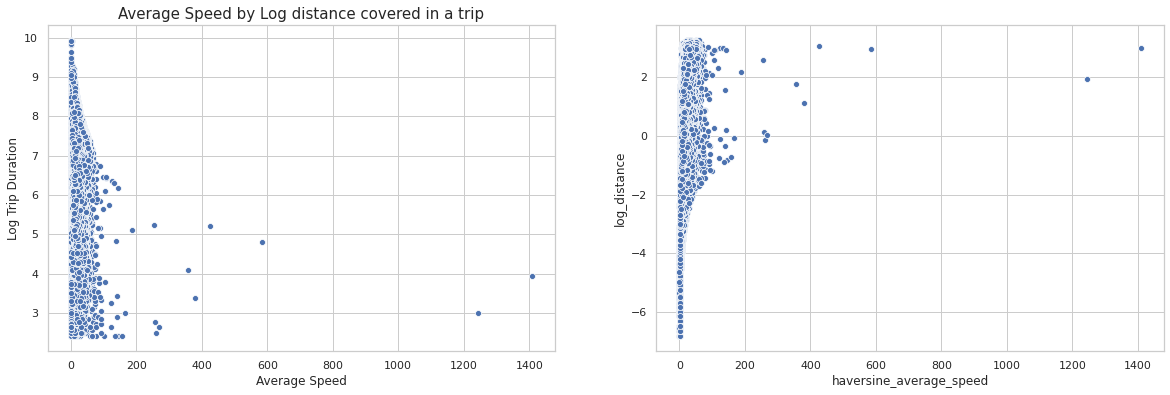

In [49]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.scatterplot(x='haversine_average_speed', y='log_trip_duration', data=df)
plt.ylabel('Log Trip Duration')
plt.xlabel('Average Speed')
plt.title('Average Speed by Log distance covered in a trip', fontsize=15)

plt.subplot(1,2,2)
sns.scatterplot(x='haversine_average_speed', y='log_distance', data=df)
plt.show()

* We can see observations which have average speed more than 400 Kmph. The Taxi are certainly not capable to ride at such high speed. Of course, it is a taxi and no supercar :P
* Intuitively, we understand it is very difficult to ride at a average speed more than 100Kmph. Therefore, we'll restrict the observations which are having an average speed more than 100 Kmph.

In [50]:
print('Total no. of observations with average speed > 70 is:',len(df.loc[df['haversine_average_speed'] > 70]))
df = df.loc[df['haversine_average_speed'] <= 70]

Total no. of observations with average speed > 70 is: 78


In [51]:
print('Total rows removed = {}, which makes only {}% of the entire data'.format(nyc_df.shape[0] - df.shape[0], 
                                                                                round(((nyc_df.shape[0] - df.shape[0])/nyc_df.shape[0])*100,4)))
df.reset_index(drop=True, inplace=True)

Total rows removed = 14265, which makes only 1.9559% of the entire data


### `New Data inclusion: Fastest route by road`

Here we will use data extracted from The Open Source Routing Machine or OSRM for each trip in our original dataset. OSRM is a C++ implementation of a high-performance routing engine for shortest paths in road networks. This will give us a very good estimate of distances between pickup and dropoff Points

Source: http://project-osrm.org/

In [53]:
fr1 = pd.read_csv('fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
fr2 = pd.read_csv('fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

df_street_info = pd.concat((fr1, fr2))
df = df.merge(df_street_info, how='left', on='id')

df_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 715057 entries, 0 to 715056
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       715057 non-null  object        
 1   vendor_id                715057 non-null  object        
 2   pickup_datetime          715057 non-null  datetime64[ns]
 3   dropoff_datetime         715057 non-null  datetime64[ns]
 4   passenger_count          715057 non-null  int64         
 5   pickup_longitude         715057 non-null  float64       
 6   pickup_latitude          715057 non-null  float64       
 7   dropoff_longitude        715057 non-null  float64       
 8   dropoff_latitude         715057 non-null  float64       
 9   store_and_fwd_flag       715057 non-null  object        
 10  trip_duration            715057 non-null  int64         
 11  pickup_day               715057 non-null  int64         
 12  pickup_weekday  

### Label Encoding

In [55]:
df['vendor_id'] = df['vendor_id'].astype(int)
df['vendor_id'] = df['vendor_id'] - 1

In [56]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(lambda x: 1 if x == 'Y' else 0)

In [57]:
np.sum(df.isnull())

id                         0
vendor_id                  0
pickup_datetime            0
dropoff_datetime           0
passenger_count            0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
store_and_fwd_flag         0
trip_duration              0
pickup_day                 0
pickup_weekday             0
pickup_weekofyear          0
pickup_month               0
pickup_hour                0
pickup_minute              0
pickup_date                0
log_trip_duration          0
distance_haversine         0
direction                  0
haversine_average_speed    0
trip_duration_hour         0
log_distance               0
total_distance             1
total_travel_time          1
number_of_steps            1
dtype: int64

In [58]:
# For the missing values we'll impute 0
df.fillna(0, inplace = True)

# Model Building

Before starting with model building, we need to eliminate few variables which aren't important for our model.

* *distance_haversine* will be removed as we have taken a log transformation of it..
* *trip_duration* will be removed as we have corresponding log transformed variable as our target variable.
* *haversine_average_speed* will also be removed. For a model to be realistic, we need to have only that variables which are known before trip starts. Speed of trip will never be known before a trip starts.

In [59]:
final_df = df.copy()
final_df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_date', 'trip_duration',
               'distance_haversine', 'trip_duration_hour','haversine_average_speed'], axis=1, inplace=True)

In [60]:
final_df.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'pickup_day', 'pickup_weekday', 'pickup_weekofyear', 'pickup_month',
       'pickup_hour', 'pickup_minute', 'log_trip_duration', 'direction',
       'log_distance', 'total_distance', 'total_travel_time',
       'number_of_steps'],
      dtype='object')

In [61]:
X = final_df.drop('log_trip_duration',axis=1)
Y = final_df['log_trip_duration']

Text(0.5, 1.0, 'Heatmap depicting correlation between features')

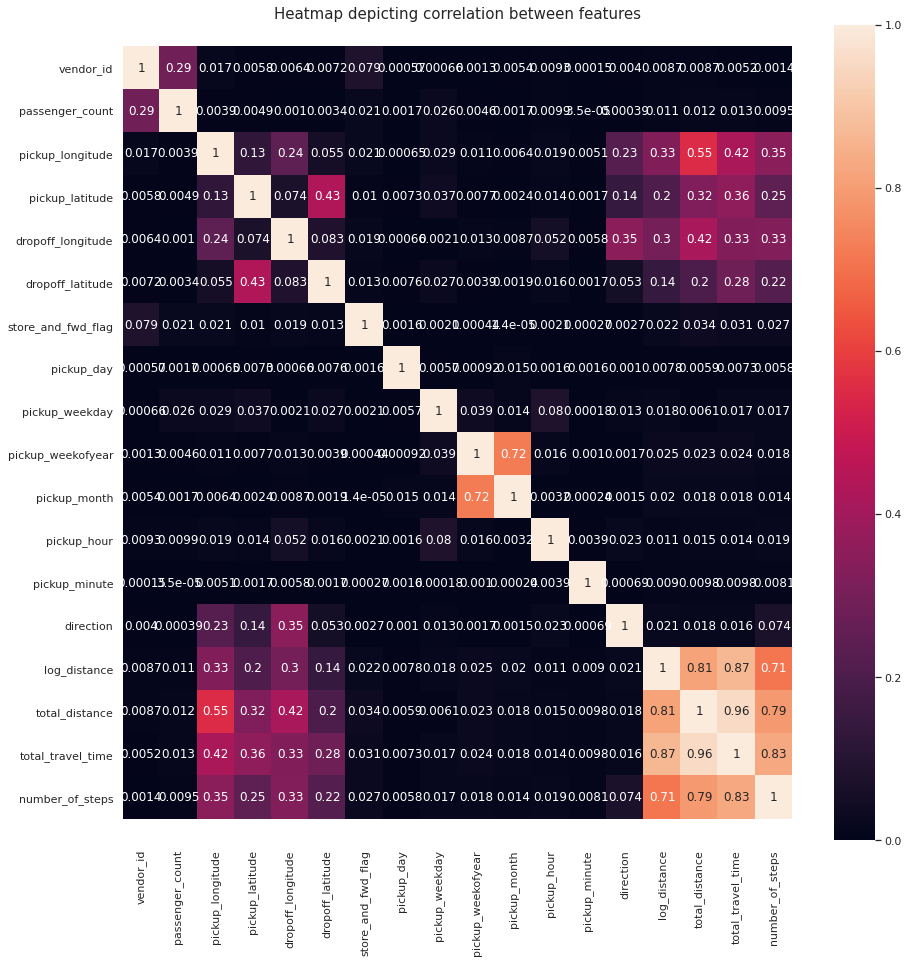

In [62]:
plt.figure(figsize = (15,15))
ax=sns.heatmap(X.corr().abs(), vmin=0, vmax=1, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Heatmap depicting correlation between features', fontsize=15)

It's evident from correlation heatmap that *total_distance, total_travel_time* are inducing high multicollinearity. Due to these variables, the oefficients of other variables may inflate in the model. Therefore,it is safe to remove the high collinear variables, preferably any one variable from a pair of variables with correlation > 0.8.

In [63]:
variables_to_remove = ['total_distance', 'total_travel_time']
selected_features = list(set(X.columns) - set(variables_to_remove))
selected_features

['log_distance',
 'pickup_hour',
 'pickup_month',
 'vendor_id',
 'store_and_fwd_flag',
 'number_of_steps',
 'pickup_longitude',
 'dropoff_latitude',
 'pickup_weekofyear',
 'pickup_minute',
 'pickup_day',
 'direction',
 'passenger_count',
 'dropoff_longitude',
 'pickup_weekday',
 'pickup_latitude']

In [64]:
X_sel_final = X[selected_features]

### `Feature Scaling`

In [65]:
# Initializing the StandardScaler
scaler = StandardScaler()
variables = X_sel_final.columns

# Standardize all the feature columns
x_array = scaler.fit_transform(X_sel_final)
x_scaled = pd.DataFrame(x_array, columns=variables)

#y_mean = Y.mean()
#Y = Y - y_mean

### `Splitting Train and Test data`

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled,Y,test_size=0.2, random_state=1001)

In [67]:
y_train = y_train.values
y_test = y_test.values


In [68]:
print('Train set = {} records, Test set = {} records'.format(y_train.shape[0],y_test.shape[0]))

Train set = 572045 records, Test set = 143012 records


In [69]:
x_train.head(2)

,log_distance,pickup_hour,pickup_month,vendor_id,store_and_fwd_flag,number_of_steps,pickup_longitude,dropoff_latitude,pickup_weekofyear,pickup_minute,pickup_day,direction,passenger_count,dropoff_longitude,pickup_weekday,pickup_latitude
64769,-0.696373,0.372472,1.477261,-1.071744,-0.074054,-0.109253,-0.143998,-0.165132,1.305659,-0.899886,0.977064,-1.471535,-0.504399,-0.248398,0.487689,0.226383
53820,-3.147119,0.529159,-0.307860,0.933059,-0.074054,-0.805216,-0.347867,-0.252222,-0.214573,1.465499,0.632183,1.560038,-0.504399,-0.380139,-1.559305,-0.213908


In [70]:
x_test.head(2)

,log_distance,pickup_hour,pickup_month,vendor_id,store_and_fwd_flag,number_of_steps,pickup_longitude,dropoff_latitude,pickup_weekofyear,pickup_minute,pickup_day,direction,passenger_count,dropoff_longitude,pickup_weekday,pickup_latitude
469022,0.180955,-0.254275,0.287180,0.933059,-0.074054,0.122735,-0.721489,-0.925201,0.136250,1.292422,0.172343,1.825855,-0.504399,-0.758598,1.511185,-0.126604
666670,1.142846,-1.977830,1.477261,-1.071744,-0.074054,0.586711,0.591048,-0.286800,1.188718,0.023191,-0.287498,1.319642,-0.504399,2.576234,-1.559305,0.804824


## Model-1: Linear Regression

In [71]:
x_train_ols = sm.add_constant(x_train)
OLS_model_1 = sm.OLS(y_train, x_train_ols).fit()
OLS_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                 6.451e+04
Date:                Wed, 23 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:50:23   Log-Likelihood:            -3.4686e+05
No. Observations:              572045   AIC:                         6.938e+05
Df Residuals:                  572028   BIC:                         6.939e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.4576      0.001    1.1e+04      0.000       6.456       6.459
log_distance           0.5174      0.001    604.547      0.000       0.516       0.519
pickup_hour            0.0338      0.001     57.234      0.000       0.033       0.035
pickup_month           0.0406      0.001     47.685      0.000       0.039       0.042
vendor_id              0.0003      0.001      0.491      0.624      -0.001       0.002
store_and_fwd_flag     0.0024      0.001      4.013      0.000       0.001       0.004
number_of_steps        0.1286      0.001    144.838      0.000       0.127       0.130
pickup_longitude      -0.0172      0.001    -24.513      0.000      -0.019      -0.016
dropoff_latitude      -0.0287      0.001    -42.188      0.000      -0.030      -0.027
pickup_weekofyear     -0.0197      0.001    -23.187      0.000      -0.021      -0.018
pickup_minute         -0.0025      0.001     -4.275      0.000      -0.004      -0.001
pickup_day             0.0040      0.001      6.815      0.000       0.003       0.005
direction              0.0316      0.001     44.689      0.000       0.030       0.033
passenger_count        0.0054      0.001      8.809      0.000       0.004       0.007
dropoff_longitude     -0.0656      0.001    -90.751      0.000      -0.067      -0.064
pickup_weekday        -0.0335      0.001    -56.712      0.000      -0.035      -0.032
pickup_latitude        0.0153      0.001     21.699      0.000       0.014       0.017
==============================================================================
Omnibus:                    91385.109   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           529290.518
Skew:                           0.646   Prob(JB):                         0.00
Kurtosis:                       7.532   Cond. No.                         2.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 1080x504 with 0 Axes>

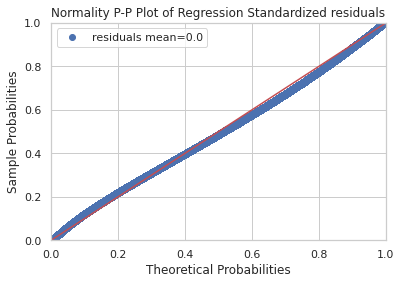

In [72]:
residuals = OLS_model_1.resid
probplot = sm.ProbPlot(residuals);
plt.figure(figsize =(15,7))
probplot.ppplot(line='45',label='residuals mean='+str(round(residuals.mean(),2)))
plt.title('Normality P-P Plot of Regression Standardized residuals' )
plt.legend(loc='4')
plt.show();

* The MLR model is giving decent accuracy of **0.643**. Also, for all the features the standard errors of the estimates are very low, approximately close to 0.
* As per the model output and p-value > 0.05, *vendor_id* is the only feature which have come out to be insignificant.
* The residuals are also **normally distributed with mean = 0**. Further we need see if multicollinearity assumption satisfies or not.

In [73]:
def get_vif(X):
    #X_matrix = X.as_matrix()
    X_matrix = X.values
    vif = [ round(variance_inflation_factor( X_matrix, i ),3) for i in range(X_matrix.shape[1]) ]
    vif_factors = pd.DataFrame()
    vif_factors['variables'] = X.columns
    vif_factors['VIF'] = vif
    return vif_factors

In [74]:
get_vif(x_train)

,variables,VIF
0,log_distance,2.125
1,pickup_hour,1.011
2,pickup_month,2.103
3,vendor_id,1.097
4,store_and_fwd_flag,1.008
5,number_of_steps,2.291
6,pickup_longitude,1.420
7,dropoff_latitude,1.348
8,pickup_weekofyear,2.107
9,pickup_minute,1.000


There are no variables which are highly correlated. We'll therefore safely remove the insignificant variables from our model.

In [75]:
final_features = list(set(selected_features) - set(['vendor_id']))

x_train_ols_2 = sm.add_constant(x_train[final_features])
OLS_model_2 = sm.OLS(y_train, x_train_ols_2).fit()
OLS_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                 6.881e+04
Date:                Wed, 23 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:50:43   Log-Likelihood:            -3.4686e+05
No. Observations:              572045   AIC:                         6.938e+05
Df Residuals:                  572029   BIC:                         6.939e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.4576      0.001    1.1e+04      0.000       6.456       6.459
log_distance           0.5174      0.001    604.566      0.000       0.516       0.519
pickup_hour            0.0338      0.001     57.238      0.000       0.033       0.035
pickup_month           0.0406      0.001     47.683      0.000       0.039       0.042
store_and_fwd_flag     0.0023      0.001      3.987      0.000       0.001       0.003
number_of_steps        0.1286      0.001    144.838      0.000       0.127       0.130
pickup_longitude      -0.0172      0.001    -24.509      0.000      -0.019      -0.016
dropoff_latitude      -0.0287      0.001    -42.188      0.000      -0.030      -0.027
pickup_weekofyear     -0.0197      0.001    -23.186      0.000      -0.021      -0.018
pickup_minute         -0.0025      0.001     -4.274      0.000      -0.004      -0.001
pickup_day             0.0040      0.001      6.815      0.000       0.003       0.005
direction              0.0316      0.001     44.689      0.000       0.030       0.033
passenger_count        0.0055      0.001      9.343      0.000       0.004       0.007
dropoff_longitude     -0.0656      0.001    -90.750      0.000      -0.067      -0.064
pickup_weekday        -0.0335      0.001    -56.716      0.000      -0.035      -0.032
pickup_latitude        0.0153      0.001     21.703      0.000       0.014       0.017
==============================================================================
Omnibus:                    91386.642   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           529297.179
Skew:                           0.646   Prob(JB):                         0.00
Kurtosis:                       7.532   Cond. No.                         2.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Model Inference:**

* All the variables in the models are statistically significant as **p-value < 0.05**.
* The overall model is also significant as the **F-statistic is large** and the p-value for F-statistic is also **less than 0.05**.
* With these 15 variables, the model is able to explain **64.3%** of variation in our target variable, *trip_duartion*. 
* This might indicate that the non-linear relationship which exists between the predictors and target variable isn't well captured here. 
* Adding **haversine_average_speed** will increase the accuracy to great extent i.e. close to 0.90. But doing so the model won't be realistic as we never know the average speed of taxi trip before the trip starts. Moreover doing so, most of the assumptions will not statisfy for the model too.

### Cross-Validation

In [76]:
def KFold_CV_performance(model,train_x,train_y,splits):
    RMSE=list()
    
    # Fitting the model
    model.fit(train_x,train_y)
    y_pred = model.predict(train_x)
    
    folds = KFold(n_splits = splits, shuffle = True, random_state = 100)
    scores = cross_val_score(model, train_x, train_y, scoring='neg_mean_squared_error', cv=folds)
    print('Cross-Validation Model Summary')
    print('='*100)
    for i in range(len(scores)):
        rmse = np.sqrt(np.abs(scores[i]))
        print('\nSplit - {} of KFold = {}, RMSE: {:.4f}'.format(i+1,splits,rmse))
        RMSE.append(rmse)
    print('\n {}-Fold CV summary: Mean RMSE = {:.4f} | Std.Dev. = {:.4f} | Min. = {:.4f} | Max. = {:.4f}'
          .format(splits,np.mean(RMSE),np.std(RMSE),np.min(RMSE),np.max(RMSE)))
    
    print('='*50)
    print('\nRMSE of LR Model in log scale:',np.sqrt(mean_squared_error(train_y,y_pred)))
    print('\nMAPE of LR Model in log scale:',np.mean(np.abs((train_y - y_pred) / (train_y))) * 100)
    print('\nAccuracy of LR Model in log scale:',r2_score(train_y,y_pred))    
    print('*'*50)
    print('\nRMSE of LR Model in original scale:',np.sqrt(mean_squared_error(np.exp(train_y),np.exp(y_pred))))
    print('\nMAPE of LR Model in original scale:',np.mean(np.abs((np.exp(train_y) - np.exp(y_pred)) / np.exp(train_y))) * 100)
    print('\nAccuracy of LR Model in original scale:',r2_score(np.exp(train_y),np.exp(y_pred)))



In [77]:
final_model = LinearRegression()
KFold_CV_performance(final_model,x_train,y_train,10)

Cross-Validation Model Summary

Split - 1 of KFold = 10, RMSE: 0.4422

Split - 2 of KFold = 10, RMSE: 0.4455

Split - 3 of KFold = 10, RMSE: 0.4450

Split - 4 of KFold = 10, RMSE: 0.4451

Split - 5 of KFold = 10, RMSE: 0.4453

Split - 6 of KFold = 10, RMSE: 0.4396

Split - 7 of KFold = 10, RMSE: 0.4443

Split - 8 of KFold = 10, RMSE: 0.4416

Split - 9 of KFold = 10, RMSE: 0.4446

Split - 10 of KFold = 10, RMSE: 0.4440

 10-Fold CV summary: Mean RMSE = 0.4437 | Std.Dev. = 0.0018 | Min. = 0.4396 | Max. = 0.4455

RMSE of LR Model in log scale: 0.4437080296312925

MAPE of LR Model in log scale: 5.389780653453304

Accuracy of LR Model in log scale: 0.6434233678488921
**************************************************

RMSE of LR Model in original scale: 401.32702189398043

MAPE of LR Model in original scale: 35.41723137250638

Accuracy of LR Model in original scale: 0.6135141898076619


## `Residual Analysis`

In [78]:
#final_model = LinearRegression()
final_model.fit(x_train,y_train)
y_pred = final_model.predict(x_train)


<Figure size 1080x504 with 0 Axes>

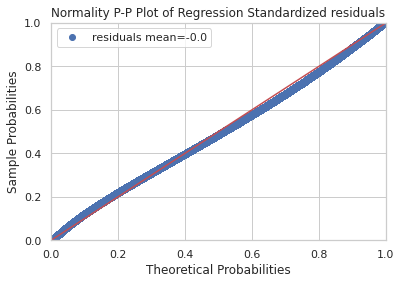

In [79]:
residuals = y_train - y_pred
probplot = sm.ProbPlot(residuals);
plt.figure(figsize =(15,7))
probplot.ppplot(line='45',label='residuals mean='+str(round(residuals.mean(),2)))
plt.title('Normality P-P Plot of Regression Standardized residuals' )
plt.legend(loc='4')
plt.show();

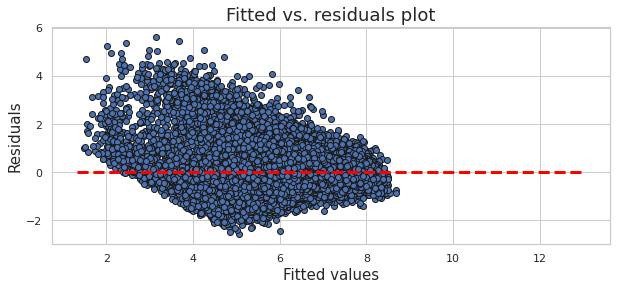

In [80]:
plt.figure(figsize=(10,4))
p=plt.scatter(x=y_pred,y=residuals,edgecolor='k')
#plt.ylim(-10,10)
#plt.xlim(-10,15)
xmin=min(y_pred)
xmax = max(y_pred)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.5,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

## `Feature Importance`

In [81]:
coeff_df = pd.DataFrame({'features':OLS_model_2.params[1:].index,'coefficients':OLS_model_2.params[1:]})
coeff_df.sort_values(by='coefficients', ascending=False, inplace=True)

Text(0, 0.5, 'Features')

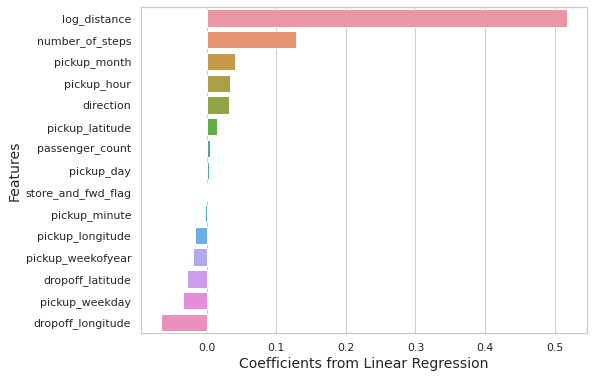

In [82]:
 ## Creating a bar plot for feature importance
plt.figure( figsize = ( 8, 6 ))
sns.barplot(x='coefficients', y='features', data=coeff_df);
plt.xlabel('Coefficients from Linear Regression',fontsize=14)
plt.ylabel('Features',fontsize=14)

## `Inference`:

* All the parameters are linear to the model.

* From the residual anaysis, we can see the residuals are **normally distributed with mean = 0**. Moreover there seems to have constant variance around the mean, indicating no prescence of **heteroscedasticity**.

* There is no high correlation between the independent variables, indicating **no multicollinearity**.

* Moreover, there is little to no presence of outliers in the model as evident from the residual plot.


## Model-2: Decision Tree

In [83]:
# Maximum number of depth in each tree:
max_depth = [3,4,5,6,7,8,9,10,11]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]

In [84]:
tree_model = DecisionTreeRegressor()

tree_param_grid = { 
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

regTree_model = RandomizedSearchCV(estimator=tree_model, param_distributions=tree_param_grid, cv=5, n_jobs=-1)
regTree_model.fit(x_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                                                   splitter='best'),
                   iid='d

In [85]:
regTree_model.cv_results_

{'mean_fit_time': array([2.16966419, 7.48992558, 4.2194809 , 2.13963675, 2.14225473,
        2.8410429 , 6.8985899 , 3.54169874, 2.8342907 , 5.86709776]),
 'mean_score_time': array([0.01371675, 0.02742019, 0.01726584, 0.01399236, 0.01348205,
        0.01439223, 0.02353921, 0.01608963, 0.01739082, 0.02119679]),
 'mean_test_score': array([0.61528343, 0.74170452, 0.68889028, 0.61528343, 0.61528343,
        0.64802051, 0.73463261, 0.66870801, 0.64802051, 0.72743675]),
 'param_max_depth': masked_array(data=[3, 11, 6, 3, 3, 4, 10, 5, 4, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[5, 2, 5, 5, 2, 1, 1, 2, 2, 2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[50, 50, 1

In [86]:
regTree_model.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [87]:
#tree_model = DecisionTreeRegressor(min_samples_split=25,min_samples_leaf=2)
tree_model = regTree_model.best_estimator_
tree_model.fit(x_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')


RMSE of Tree Model in log scale: 0.36705841763489017
Accuracy of Tree Model in log scale: 0.7559781705377646
=-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-=

RMSE of Tree Model in original scale: 331.22038208301774
Accuracy of Tree Model in original scale: 0.73674849884303


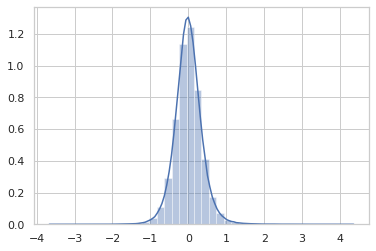

In [88]:
tree_y_pred = tree_model.predict(x_train)
sns.distplot(y_train-tree_y_pred,bins=40)

print('\nRMSE of Tree Model in log scale:',np.sqrt(mean_squared_error(y_train,tree_y_pred)))
print('Accuracy of Tree Model in log scale:',r2_score(y_train,tree_y_pred))
print('=-='*40)
print('\nRMSE of Tree Model in original scale:',np.sqrt(mean_squared_error(np.exp(y_train),np.exp(tree_y_pred))))
print('Accuracy of Tree Model in original scale:',r2_score(np.exp(y_train),np.exp(tree_y_pred)))

<Figure size 1080x504 with 0 Axes>

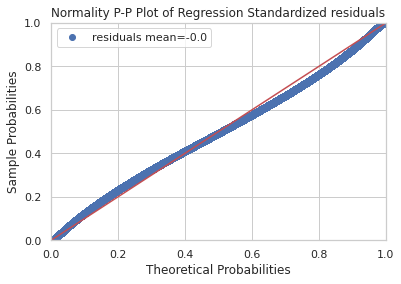

In [89]:
probplot = sm.ProbPlot(y_train-tree_y_pred);
plt.figure(figsize =(15,7))
probplot.ppplot(line='45',label='residuals mean='+str(round(residuals.mean(),2)))
plt.title('Normality P-P Plot of Regression Standardized residuals' )
plt.legend(loc='4')
plt.show();

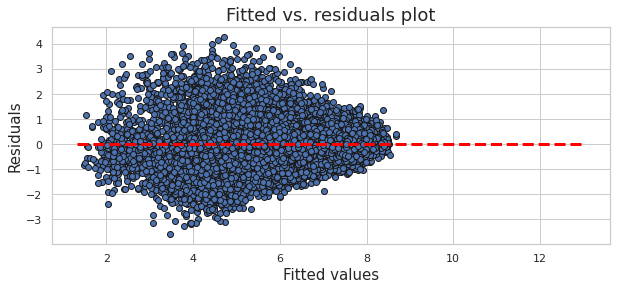

In [90]:
plt.figure(figsize=(10,4))
p=plt.scatter(x=y_pred,y=(y_train-tree_y_pred),edgecolor='k')
#plt.ylim(-10,10)
#plt.xlim(-10,15)
xmin=min(y_pred)
xmax = max(y_pred)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.5,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

Text(0, 0.5, 'Features')

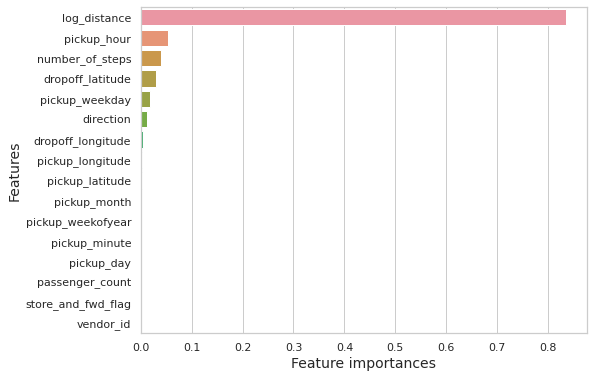

In [91]:
feature_imp_df = pd.DataFrame({'features':x_train.columns,'importance':tree_model.feature_importances_})
feature_imp_df.sort_values(by='importance', ascending=False, inplace=True)

 ## Creating a bar plot for feature importance
plt.figure( figsize = ( 8, 6 ))
sns.barplot(x='importance', y='features', data=feature_imp_df);
plt.xlabel('Feature importances',fontsize=14)
plt.ylabel('Features',fontsize=14)

# Final Prediction on Test Data

In [92]:
x_test.reset_index(drop=True,inplace=True)
#x_test_final = x_test[most_significant_features]
y_pred_test = regTree_model.predict(x_test)

In [93]:

print('\nRMSE for test data in log scale:',np.sqrt(mean_squared_error(y_test,y_pred_test)))
print('MAPE of test data in original scale:',np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100)
print('Accuracy for test data in log scale:',r2_score(y_test,y_pred_test))
print('=-='*40)
print('\nRMSE for test data in original scale:',np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_pred_test))))
print('MAPE of test data in original scale:',np.mean(np.abs((np.exp(y_test) - np.exp(y_pred_test)) / (np.exp(y_test))) * 100))
print('Accuracy for test data in original scale:',r2_score(np.exp(y_test),np.exp(y_pred_test)))



RMSE for test data in log scale: 0.3755829882643892
MAPE of test data in original scale: 4.476896961081085
Accuracy for test data in log scale: 0.7451972089566952
=-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-=

RMSE for test data in original scale: 342.2002046576536
MAPE of test data in original scale: 29.471708048070084
Accuracy for test data in original scale: 0.7234602305906472


In [94]:
y_test = np.exp(y_test)
y_pred_test = np.exp(y_pred_test)

In [95]:
prediction_df = pd.DataFrame({'Actual':y_test,'Predicted':y_pred_test})
prediction_df.reset_index(drop=True,inplace=True)

In [96]:
prediction_df

,Actual,Predicted
0,769.0,947.615772
1,1110.0,1035.907145
2,265.0,212.074806
3,3009.0,2947.637613
4,1096.0,986.300806
...,...,...
143007,752.0,970.056331
143008,788.0,1035.907145
143009,518.0,589.939509
143010,338.0,270.557607


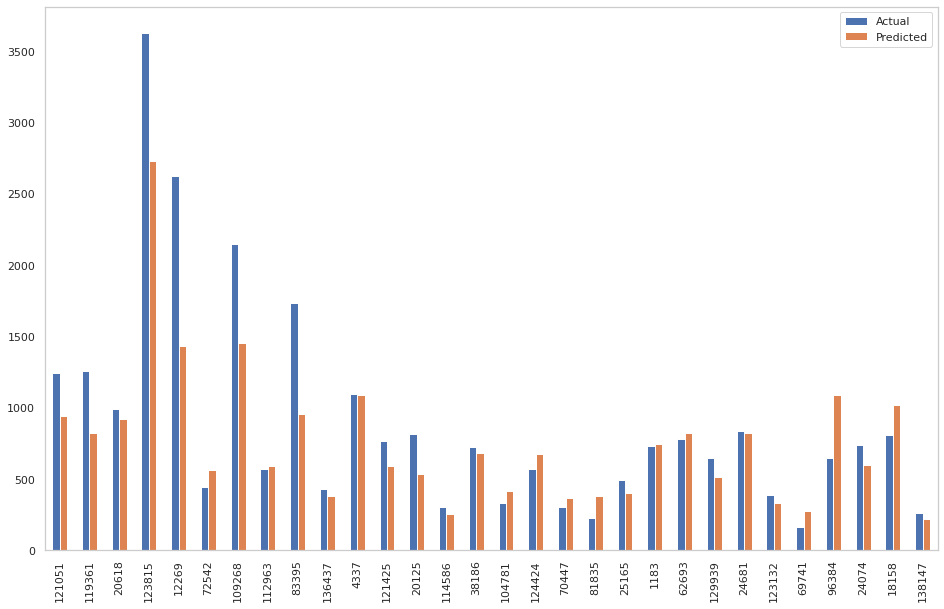

In [97]:
df = prediction_df.sample(30)
df.plot(kind='bar',figsize=(16,10),grid=False)
plt.show()

## Conclusion:

**Decision Tree** model is able to capture majority of the variation in the target variable i.e ***74% variation*** compared to a linear regression model. It is worth noticing that only 6 variables are able to give such good results. Smart feature engineering techniques can be further explored to see reduction in RMSE. 

There definitely lies scope to apply complex models like Random forest, Xgboost, LightGBM etc. which can give best results in predicting the taxi trip duration.